**EMAIL SPAM DETECTION WITH MACHINE LEARNING**

**Problem Statement**

Email spam, or junk mail, remains a persistent issue, flooding inboxes with unsolicited and often malicious content. These emails may contain cryptic messages, scams, or, most dangerously, phishing attempts. Our task, undertaken during an engaging data science internship provided by Oasis Infobyte, is to create an effective email spam detection system using Python and machine learning.

**Problem Objective**

The objective of email spam detection with machine learning is to automatically identify and filter out unsolicited or unwanted emails (spam) from legitimate ones (ham) using computational algorithms. By employing machine learning techniques, the goal is to develop a model that can accurately classify incoming emails as either spam or legitimate based on their content, metadata, sender information, and other relevant features.

**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

from imblearn.over_sampling import RandomOverSampler

**Loading Dataset**

In [ ]:
#Dataset
data=pd.read_csv("/content/spam.csv", encoding="latin-1")
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
#Drop irrelevant columns and rename columns
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1, inplace=True)
data.rename(columns={'v1':'Target','v2':'Text'}, inplace=True)

In [ ]:
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.groupby("Target").describe()

Text                                                               
       count unique                                                top freq
Target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

**Visualising the Dataset**

<ipython-input-7-7f2a1d3245a2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fg=sns.countplot(x=data["Target"], palette=cols)


Text(0, 0.5, 'Count')

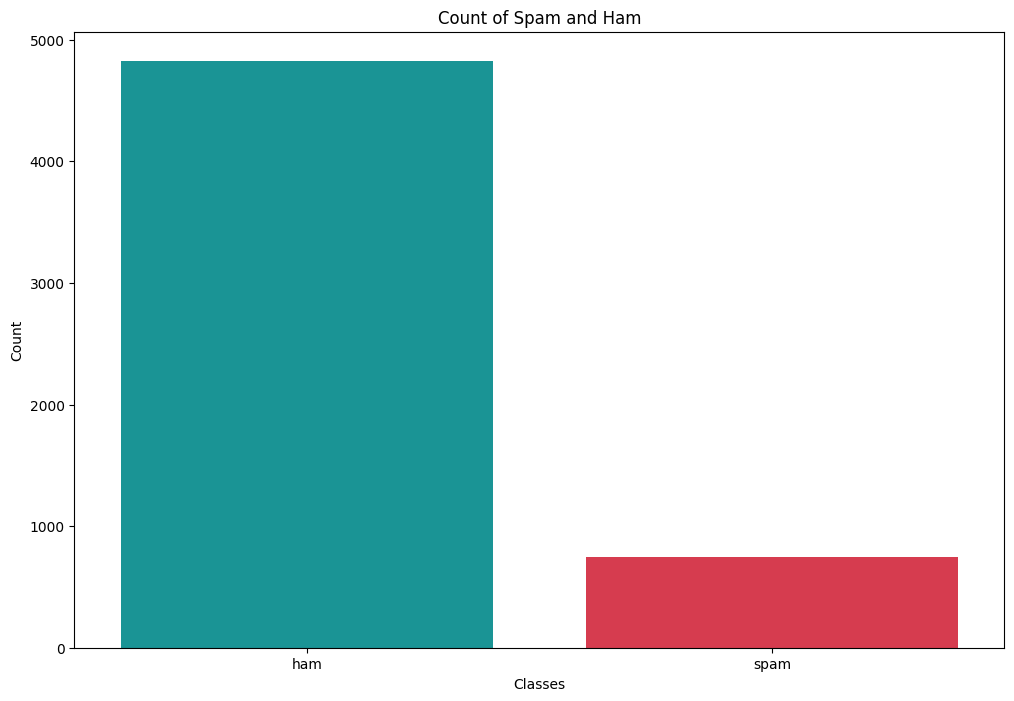

In [ ]:
#palette
cols=["#05A8AA","#EF233C"]
plt.figure(figsize=(12,8))
fg=sns.countplot(x=data["Target"], palette=cols)
fg.set_title("Count of Spam and Ham")
fg.set_xlabel("Classes")
fg.set_ylabel("Count")

In [ ]:
data["Text_Length"]=data["Text"].apply(len)

In [ ]:
data.head()

,Target,Text,Text_Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


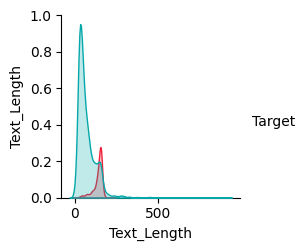

In [ ]:
sns.pairplot(data=data,hue='Target', palette=cols)

<Axes: ylabel='Text_Length'>

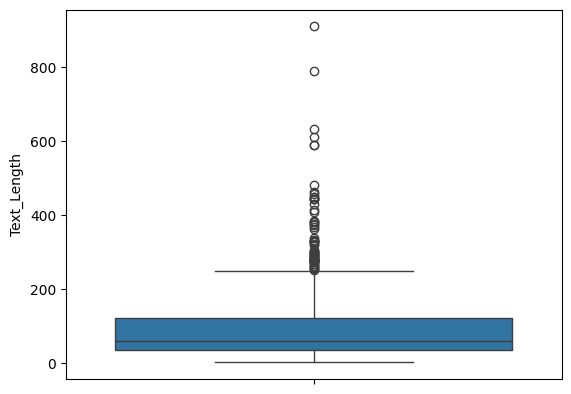

In [ ]:
sns.boxplot(data["Text_Length"])

In [ ]:
print(data[data["Text_Length"]>450].count())

Target         9
Text           9
Text_Length    9
dtype: int64


**Data Preprocessing**

1. Data Cleaning

In [ ]:
print(data["Text"][:10])

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: Text, dtype: object


In [ ]:
def clean(text):
    sms= re.sub('[^a-zA-Z]', " ", text)
    sms=sms.lower()

    #remove extra whitespaces
    sms= sms.split()
    sms= ' '.join(sms)
    return sms

data["Cleaned_text"]=data["Text"].apply(clean)

In [ ]:
print(data["Cleaned_text"][:10])

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in a wkly comp to win fa cup final ...
3          u dun say so early hor u c already then say
4    nah i don t think he goes to usf he lives arou...
5    freemsg hey there darling it s been week s now...
6    even my brother is not like to speak with me t...
7    as per your request melle melle oru minnaminun...
8    winner as a valued network customer you have b...
9    had your mobile months or more u r entitled to...
Name: Cleaned_text, dtype: object


2.Tokenization

 Tokenization is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words.

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data["Tokenized_text"]=data.apply(lambda row: nltk.word_tokenize(row["Cleaned_text"]), axis=1)

In [ ]:
print(data["Tokenized_text"][:10])

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, a, wkly, comp, to, win, fa, ...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
5    [freemsg, hey, there, darling, it, s, been, we...
6    [even, my, brother, is, not, like, to, speak, ...
7    [as, per, your, request, melle, melle, oru, mi...
8    [winner, as, a, valued, network, customer, you...
9    [had, your, mobile, months, or, more, u, r, en...
Name: Tokenized_text, dtype: object


3. Remove Stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_stopwords(text):
    stop_words=set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_text"] = data["Tokenized_text"].apply(remove_stopwords)

In [ ]:
print(data["Nostopword_text"][:10])

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
5    [freemsg, hey, darling, week, word, back, like...
6    [even, brother, like, speak, treat, like, aids...
7    [per, request, melle, melle, oru, minnaminungi...
8    [winner, valued, network, customer, selected, ...
9    [mobile, months, u, r, entitled, update, lates...
Name: Nostopword_text, dtype: object


4. Stemming

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stemmer = PorterStemmer()
def stem_word(text):
    stems = [stemmer.stem(word) for word in text]
    return stems
data["Stemmed_text"] = data["Nostopword_text"].apply(stem_word)

In [ ]:
print(data["Stemmed_text"][:10])

0    [go, jurong, point, crazi, avail, bugi, n, gre...
1                         [ok, lar, joke, wif, u, oni]
2    [free, entri, wkli, comp, win, fa, cup, final,...
3        [u, dun, say, earli, hor, u, c, alreadi, say]
4         [nah, think, goe, usf, live, around, though]
5    [freemsg, hey, darl, week, word, back, like, f...
6    [even, brother, like, speak, treat, like, aid,...
7    [per, request, mell, mell, oru, minnaminungint...
8    [winner, valu, network, custom, select, receiv...
9    [mobil, month, u, r, entitl, updat, latest, co...
Name: Stemmed_text, dtype: object


**Vectorization**

Steps in the Vectorizing:

Creating a corpus of lemmatized text

Converting the corpus in vector form

Label Encoding the classes in Target


In [ ]:
corpus= []
for i in data["Stemmed_text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though']

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
X.dtype

dtype('float64')

In [ ]:
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

**Class Imbalance Handling**

To perform oversampling, undersampling, or other balancing techniques to address class imbalance.

In [ ]:
y = data["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [ ]:
oversampler=RandomOverSampler(random_state=11)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

<ipython-input-30-fa5d589ea11d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=resampled_df, palette=cols)


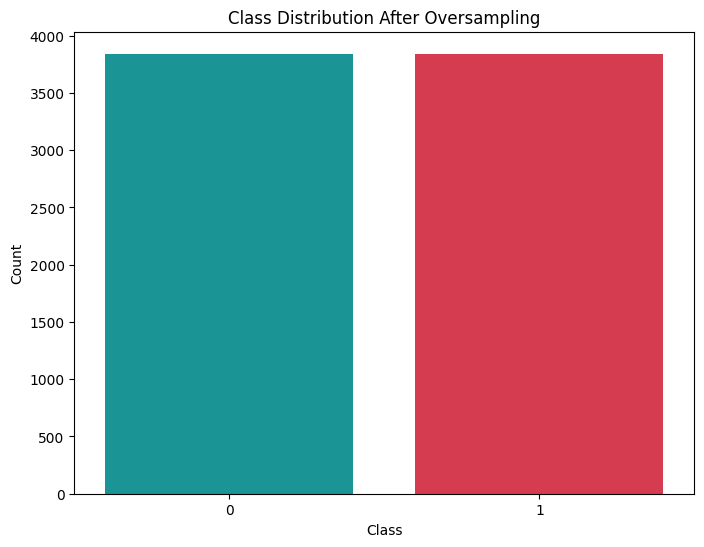

In [ ]:
resampled_df = pd.DataFrame({'Target': y_train})

plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=resampled_df, palette=cols)
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

**Model Building**

In [ ]:
classifiers = [MultinomialNB(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

**Model Evaluation**

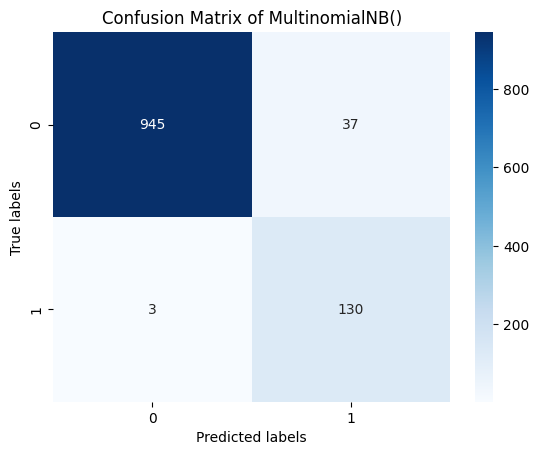

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       982
           1       0.78      0.98      0.87       133

    accuracy                           0.96      1115
   macro avg       0.89      0.97      0.92      1115
weighted avg       0.97      0.96      0.97      1115



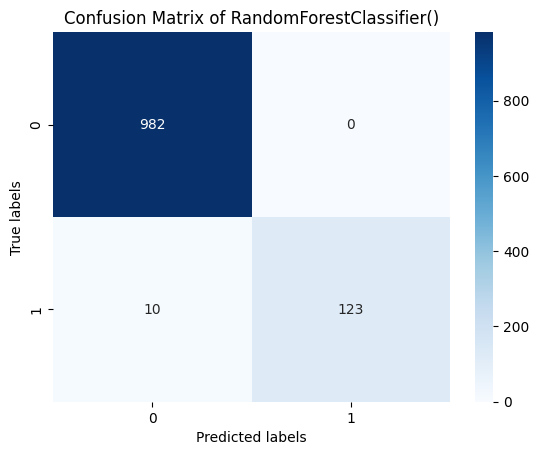

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       982
           1       1.00      0.92      0.96       133

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115



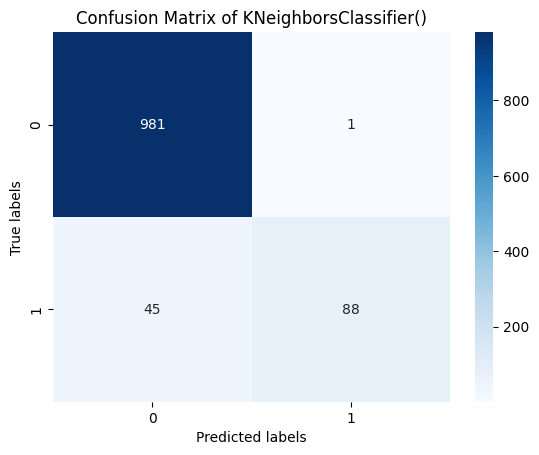

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       982
           1       0.99      0.66      0.79       133

    accuracy                           0.96      1115
   macro avg       0.97      0.83      0.88      1115
weighted avg       0.96      0.96      0.96      1115



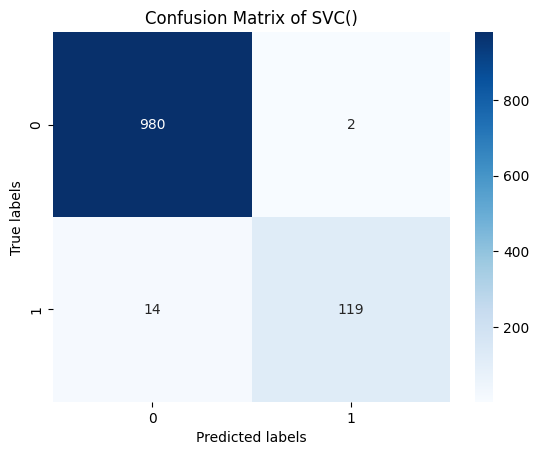

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       982
           1       0.98      0.89      0.94       133

    accuracy                           0.99      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.99      0.99      0.99      1115



In [ ]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
sensitivity_list = []
specificity_list = []
fpr_list = []
fnr_list = []
npv_list = []
fdr_list = []
mcc_list = []

for cls in classifiers:

    y_pred = cls.predict(X_test)

    # Confusion Matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix of {cls}')
    plt.show()


    print(classification_report(y_test, y_pred))


    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (fn + tp)
    f1 = 2 * (precision * recall) / (precision + recall)
    sensitivity = tp / (fn + tp)
    specificity = tn / (tn + fp)
    fpr = fp / (tn + fp)
    fnr = fn / (fn + tp)
    npv = tn / (tn + fn)
    fdr = fp / (fp + tp)
    mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5


    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    fpr_list.append(fpr)
    fnr_list.append(fnr)
    npv_list.append(npv)
    fdr_list.append(fdr)
    mcc_list.append(mcc)

metrics_df = pd.DataFrame({
    'Model': [pipe_dict[i] for i in range(len(pipe_dict))],
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Measure': f1_list,
    'Sensitivity': sensitivity_list,
    'Specificity': specificity_list,
    'FPR': fpr_list,
    'FNR': fnr_list,
    'NPV': npv_list,
    'FDR': fdr_list,
    'MCC': mcc_list
})

In [ ]:
metrics_df.transpose()

,0,1,2,3
Model,NaiveBayes,RandomForest,KNeighbours,SVC
Accuracy,0.964126,0.991031,0.958744,0.98565
Precision,0.778443,1.0,0.988764,0.983471
Recall,0.977444,0.924812,0.661654,0.894737
F1-Measure,0.866667,0.960938,0.792793,0.937008
Sensitivity,0.977444,0.924812,0.661654,0.894737
Specificity,0.962322,1.0,0.998982,0.997963
FPR,0.037678,0.0,0.001018,0.002037
FNR,0.022556,0.075188,0.338346,0.105263
NPV,0.996835,0.989919,0.95614,0.985915
